# LInear Elasticity
static

In [1]:
import numpy as np
from ufl import sym, grad, Identity, tr, inner, Measure, TestFunction, TrialFunction

from mpi4py import MPI

from dolfinx import fem, io
import dolfinx.fem.petsc
from dolfinx.mesh import create_rectangle, CellType

length, height = 10, 1.0
Nx, Ny = 50, 5
domain = create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([length, height])],
    [Nx, Ny],
    cell_type=CellType.quadrilateral,
)

dim = domain.topology.dim
print(f"Mesh topology dimension d={dim}.")

Mesh topology dimension d=2.


In [2]:
degree = 2
shape = (dim,)  # this means we want a vector field of size `dim`
V = fem.functionspace(domain, ("P", degree, shape))

u_sol = fem.Function(V, name="Displacement")

We now define the various UFL expressions which will enter our variational formulation. For this, we wrap material parameters as `Constant`.

In [3]:
E = fem.Constant(domain, 210e3)
nu = fem.Constant(domain, 0.3)

lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)

def epsilon(v):
    return sym(grad(v))

def sigma(v):
    return lmbda * tr(epsilon(v)) * Identity(dim) + 2 * mu * epsilon(v)

We can check that such objects are indeed abstract UFL expressions (they are represented as graphs internally).

print("mu (UFL):\n", mu)
print("epsilon (UFL):\n", epsilon(u_sol))
print("sigma (UFL):\n", sigma(u_sol))

We now define the corresponding linear and bilinear forms. Below, `dx` is the volume integration measure on the whole domain.

In [4]:
u = TrialFunction(V)
v = TestFunction(V)

rho = 2e-3
g = 9.81
f = fem.Constant(domain, np.array([0, -rho * g]))
## thermal
x = ufl.SpatialCoordinate(domain)


dx = Measure("dx", domain=domain)
a = inner(sigma(u), epsilon(v)) * dx
L = inner(f, v) * dx

We now define boundary conditions. For simplicity, we first fix both the left and right boundaries. To do so, we must locate the corresponding degrees of freedom from a marker function thet returns `True` for points `x` on the boundary and `False` otherwise.

In [5]:
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], length)


left_dofs = fem.locate_dofs_geometrical(V, left)
right_dofs = fem.locate_dofs_geometrical(V, right)

bcs = [
    fem.dirichletbc(np.zeros((2,)), left_dofs, V),
    fem.dirichletbc(np.zeros((2,)), right_dofs, V),
]

Finally, a `LinearProblem` object is created based on the variational problem, the boundary conditions and a Function `u` in which we want to store the solution. We can also pass parameters to setup the solver type (here we use a direct LU factorization).
Results are then stored in a ".pvd" format to be visualized using Paraview for instance.

In [6]:
problem = fem.petsc.LinearProblem(
    a, L, u=u_sol, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()


vtk = io.VTKFile(domain.comm, "linear_elasticity.pvd", "w")
vtk.write_function(u_sol)
vtk.close()

### Changing boundary conditions

If we want to constrain only the vertical component of the displacement field on some boundary, we need to work with the corresponding subspace of the original function space `V`.

V_uy, mapping = V.sub(1).collapse()
right_dofs_uy = fem.locate_dofs_geometrical((V.sub(1), V_uy), right)

uD_y = fem.Function(V_uy)
bcs2 = [
    fem.dirichletbc(np.zeros((2,)), left_dofs, V),
    fem.dirichletbc(uD_y, right_dofs_uy, V.sub(1)),
]

problem = fem.petsc.LinearProblem(
    a, L, u=u_sol, bcs=bcs2, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()


vtk = io.VTKFile(domain.comm, "linear_elasticity.pvd", "w")
vtk.write_function(u_sol)
vtk.close()

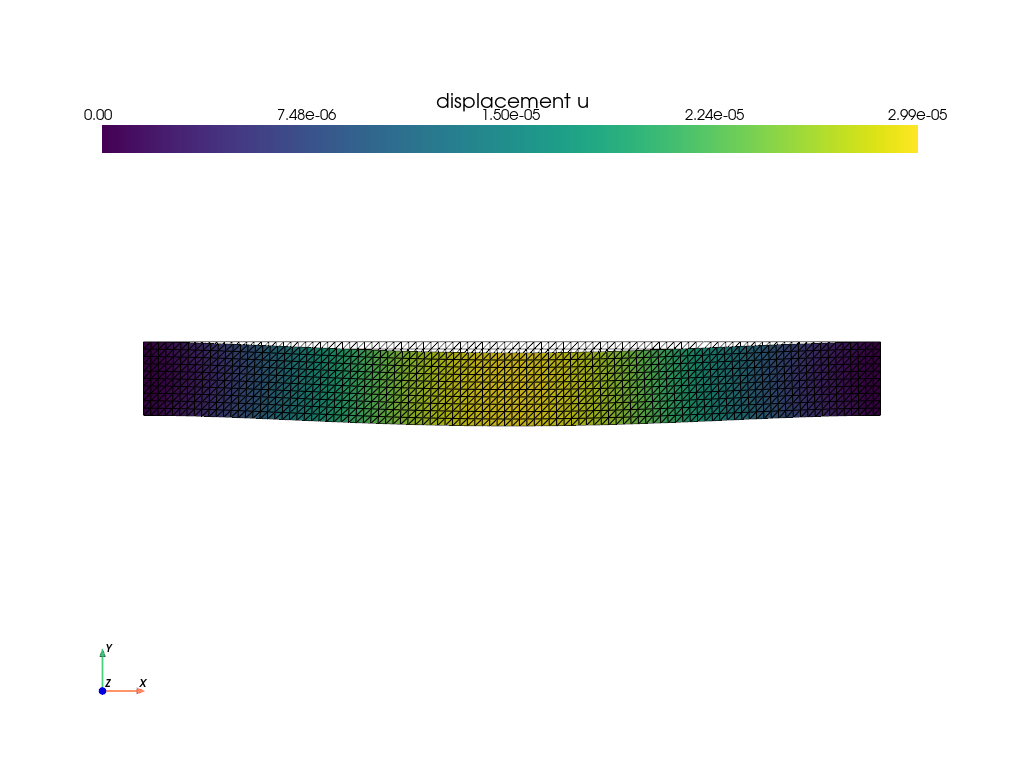

In [12]:
import pyvista
import matplotlib as mpl
pyvista.start_xvfb()
from dolfinx import plot
# Create plotter and pyvista grid
p = pyvista.Plotter()

topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = u_sol.x.array.reshape((geometry.shape[0], 2))
grid["u"] = np.hstack([ grid["u"], np.zeros((grid["u"].shape[0], 1))])

actor_0 = p.add_mesh(grid, style="wireframe", color="k",show_scalar_bar=False)
warped = grid.warp_by_vector("u", factor=5000)
actor_1 = p.add_mesh(warped, show_edges=True, show_scalar_bar=False)
p.add_scalar_bar(title="displacement u", position_x=0.1, position_y=0.8, width=0.8, height=0.1, 
                 vertical=False, title_font_size=20, label_font_size=15)
p.view_xy()
p.show_axes()

if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

NameError: name 'RectangleMesh' is not defined